In [1]:
"""
File: XGBoost.ipynb
Code to train and evaluate an XGBoost model on MIMIC-IV FHIR dataset.
"""


def Project():
    """
    __Objectives__
    0. Import data and separate unique visit tokens
    1. Reduce the number of features (manual selection, hierarchy aggregation)
    2. Create frequency features from event tokens
    3. Include num_visits, youngest and oldest age, and maybe time
    4. Use label column to create the prediction objective
    5. Train XGBoost model and evaluate on test dataset
    >>> All objectives successful
    """
    return ProjectObjectives.__doc__

In [2]:
# Import dependencies and define useful constants
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy.sparse import csr_matrix, hstack, load_npz, save_npz, vstack
from sklearn.metrics import (
    auc,
    average_precision_score,
    balanced_accuracy_score,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm


plt.style.use("seaborn-v0_8")
%matplotlib inline

ROOT = "/fs01/home/afallah/odyssey/odyssey"
os.chdir(ROOT)

DATA_ROOT = f"{ROOT}/data/slurm_data/512/two_weeks"
DATA_PATH = f"{DATA_ROOT}/pretrain.parquet"
FINE_TUNE_PATH = f"{DATA_ROOT}/fine_tune.parquet"
TEST_DATA_PATH = f"{DATA_ROOT}/fine_test.parquet"
FREQ_MATRIX_PATH = f"{DATA_ROOT}/patient_freq_matrix.npz"

In [94]:
# Load pretraining data
pretrain_data = pd.read_parquet(DATA_PATH)
pretrain_data = pretrain_data[pretrain_data["event_tokens_512"].notnull()]
pretrain_data

,patient_id,num_visits,deceased,death_after_start,death_after_end,length,token_length,event_tokens_512,type_tokens_512,age_tokens_512,time_tokens_512,visit_tokens_512,position_tokens_512,label
0,f8f3289a-057f-5fcc-a714-5f6109ca16c4,2,0,NaN,NaN,1,4,"[[CLS], [VS], 8938, [VE], [PAD], [PAD], [PAD],...","[1, 2, 7, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 18, 18, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 8262, 8262, 8262, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 2, 2, 513, 513, 513, 513, 513, 513, 513...",0
1,9b62c9f4-3fdc-5020-82b5-ae5b8292445a,4,0,NaN,NaN,43,52,"[[CLS], [VS], 7569, 66689036430, 00904224461, ...","[1, 2, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, ...","[0, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28...","[0, 5963, 5963, 5963, 5963, 5963, 5963, 5963, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
2,2ca522eb-dd89-5f79-8155-9599ea46b0b2,2,1,244.0,242.0,51,54,"[[CLS], [VS], 00904629261, 00904642281, 009046...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86...","[0, 8016, 8016, 8016, 8016, 8016, 8016, 8016, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
4,02adf8a6-8bc0-55d3-81ae-4d8582094896,9,1,20.0,11.0,640,664,"[[CLS], [VS], 52007_3, 51476_2, 50861_1, 50862...","[1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73...","[0, 8426, 8426, 8426, 8426, 8426, 8426, 8426, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...",1
5,744fe3c4-9b03-55ae-ac9f-6bc4e967cde7,3,0,NaN,NaN,80,86,"[[CLS], [VS], 7813, 7813, 7902, 7902, 9604, 00...","[1, 2, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29...","[0, 7582, 7582, 7582, 7582, 7582, 7582, 7582, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173665,23ffff2e-68c2-5f4d-80bd-e4a0f42fe468,2,0,NaN,NaN,16,19,"[[CLS], [VS], 5188, 5187, 00078048535, 0007803...","[1, 2, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, ...","[0, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49...","[0, 5791, 5791, 5791, 5791, 5791, 5791, 5791, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
173666,cf2115d7-937e-511d-b159-dd7eb3d5d420,3,0,NaN,NaN,166,172,"[[CLS], [VS], 66591018442, 63323026201, 001350...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32...","[0, 5481, 5481, 5481, 5481, 5481, 5481, 5481, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
173668,0989415d-394c-5f42-8dac-75dc7306a23c,3,0,NaN,NaN,470,476,"[[CLS], [VS], 51079043620, 51079088120, 492810...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 3, 4, 2, 7, 7, 7, ...","[0, 52, 52, 52, 52, 52, 52, 52, 52, 52, 0, 52,...","[0, 5309, 5309, 5309, 5309, 5309, 5309, 5309, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...",0
173669,26fb8fef-b976-5c55-859d-cc190261f94b,3,0,NaN,NaN,93,99,"[[CLS], [VS], 0SRD0J9, 60505251903, 0090422446...","[1, 2, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61...","[0, 5085, 5085, 5085, 5085, 5085, 5085, 5085, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0


In [95]:
# Load finetuning data
finetune_data = pd.read_parquet(FINE_TUNE_PATH)
finetune_data = finetune_data[finetune_data["event_tokens_512"].notnull()]
finetune_data

,patient_id,num_visits,deceased,death_after_start,death_after_end,length,token_length,event_tokens_512,type_tokens_512,age_tokens_512,time_tokens_512,visit_tokens_512,position_tokens_512,label
126909,8084e28f-d1ef-59c3-ace8-e9fea1142998,2,0,NaN,NaN,122,125,"[[CLS], [VS], 66758016013, 00904504561, 510790...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61...","[0, 7599, 7599, 7599, 7599, 7599, 7599, 7599, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
133431,3415643f-2289-5db3-9e4c-a990ae1bca1f,2,1,1.0,0.0,39,42,"[[CLS], [VS], 00456066270, 00409490234, 553900...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, ...","[0, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85...","[0, 7334, 7334, 7334, 7334, 7334, 7334, 7334, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
35724,bce4f470-d244-5898-98bf-a3cee3218a56,2,1,1.0,0.0,104,107,"[[CLS], [VS], 0017, 3893, 00002735501, 6332302...","[1, 2, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49...","[0, 5214, 5214, 5214, 5214, 5214, 5214, 5214, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
84776,0694f58f-89bc-541d-b1cb-d868bb84be0a,2,0,NaN,NaN,28,31,"[[CLS], [VS], 66685100101, 54569452202, 680840...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24...","[0, 7970, 7970, 7970, 7970, 7970, 7970, 7970, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
127303,3e2c572c-e145-50f0-9aa4-38dcafb194a5,2,1,16.0,2.0,908,911,"[[CLS], [VS], 50817_3, 50818_1, 50820_4, 50821...","[1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64...","[0, 6327, 6327, 6327, 6327, 6327, 6327, 6327, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18343,b72aa2f9-33ca-58d0-acaa-3e3586da9ba0,2,1,7.0,0.0,286,289,"[[CLS], [VS], 966, 9671, 9671, 9604, 9604, 000...","[1, 2, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71...","[0, 7521, 7521, 7521, 7521, 7521, 7521, 7521, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
94785,6c96ae19-132b-5675-9507-fd67c4fc7c48,2,1,10.0,6.0,172,175,"[[CLS], [VS], 63739047810, 00338004904, 009041...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65...","[0, 5016, 5016, 5016, 5016, 5016, 5016, 5016, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
20066,ba7042a4-c31d-55ee-b2df-56c1cbcdf0ab,2,1,6.0,2.0,141,144,"[[CLS], [VS], 3491, 00338004903, 00904516561, ...","[1, 2, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91...","[0, 5401, 5401, 5401, 5401, 5401, 5401, 5401, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
85586,48aad725-227a-5c75-92c6-531a65c84f89,2,1,0.0,0.0,16,19,"[[CLS], [VS], 9671, 9604, 00409490234, 5107902...","[1, 2, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, ...","[0, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91...","[0, 8402, 8402, 8402, 8402, 8402, 8402, 8402, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1


In [96]:
# Load test data
test_data = pd.read_parquet(TEST_DATA_PATH)
test_data = test_data[test_data["event_tokens_512"].notnull()]
test_length = len(test_data)
test_data

,patient_id,num_visits,deceased,death_after_start,death_after_end,length,token_length,event_tokens_512,type_tokens_512,age_tokens_512,time_tokens_512,visit_tokens_512,position_tokens_512,label
50781,21bba082-e06b-5f30-9388-d67266b97aaa,2,1,14.0,14.0,64,67,"[[CLS], [VS], 00121483940, 00904632261, 510790...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, ...","[0, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91...","[0, 7199, 7199, 7199, 7199, 7199, 7199, 7199, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
160949,30b5c2b5-1950-50e1-87cf-1e18cf555da0,2,0,NaN,NaN,47,50,"[[CLS], [VS], 0W3P8ZZ, 65649020175, 0033800850...","[1, 2, 7, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, ...","[0, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66...","[0, 7969, 7969, 7969, 7969, 7969, 7969, 7969, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
67791,48806199-3c16-552e-bfb2-ac1188fd0f91,2,1,9.0,7.0,76,79,"[[CLS], [VS], 11509021265, 87701071218, 553900...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85...","[0, 5182, 5182, 5182, 5182, 5182, 5182, 5182, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
135851,40d3939a-45c7-5396-a01a-748d7ba7b557,6,1,11.0,9.0,334,349,"[[CLS], [VS], 5421, 0531, 3893, 9915, 68084007...","[1, 2, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50...","[0, 5296, 5296, 5296, 5296, 5296, 5296, 5296, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
136632,b2d3217b-66c5-5a0e-9cad-a4cea3cc657b,4,0,NaN,NaN,266,275,"[[CLS], [VS], 00006473900, 51079045020, 001723...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88...","[0, 6608, 6608, 6608, 6608, 6608, 6608, 6608, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94984,70f9bcad-cbdc-5dc8-aba7-eb0bb6313d8c,3,1,28.0,10.0,751,757,"[[CLS], [VS], 51250_3, 51265_1, 51277_2, 51279...","[1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84...","[0, 8408, 8408, 8408, 8408, 8408, 8408, 8408, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",1
62097,0ce20eaf-af38-54cf-b2a8-2481e74370f7,11,1,18.0,12.0,839,869,"[[CLS], [VS], 51493_1, 51491_1, 51482_1, 51006...","[1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57...","[0, 6537, 6537, 6537, 6537, 6537, 6537, 6537, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",1
53452,bfcd2a4a-969e-5963-8340-d339ebd3a247,8,1,13.0,0.0,7772,7793,"[[CLS], [VS], 50954_4, 50931_1, 50912_3, 50902...","[1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51...","[0, 7818, 7818, 7818, 7818, 7818, 7818, 7818, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...",1
108716,cf46e978-3510-5c23-8d4b-bbf64bb6b28c,5,1,0.0,0.0,474,486,"[[CLS], [VS], 68084025901, 68084009901, 000882...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71...","[0, 8532, 8532, 8532, 8532, 8532, 8532, 8532, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1


In [97]:
# Combine all datasets together and remove duplicates
data = pd.concat((pretrain_data, finetune_data, test_data))
data = data.reset_index()
data = data.drop_duplicates(subset="index", keep="first").set_index("index")

# Remove unused data
del pretrain_data, finetune_data, test_data

data

,patient_id,num_visits,deceased,death_after_start,death_after_end,length,token_length,event_tokens_512,type_tokens_512,age_tokens_512,time_tokens_512,visit_tokens_512,position_tokens_512,label
index,,,,,,,,,,,,,,
0,f8f3289a-057f-5fcc-a714-5f6109ca16c4,2,0,NaN,NaN,1,4,"[[CLS], [VS], 8938, [VE], [PAD], [PAD], [PAD],...","[1, 2, 7, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 18, 18, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 8262, 8262, 8262, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 2, 2, 513, 513, 513, 513, 513, 513, 513...",0
1,9b62c9f4-3fdc-5020-82b5-ae5b8292445a,4,0,NaN,NaN,43,52,"[[CLS], [VS], 7569, 66689036430, 00904224461, ...","[1, 2, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, ...","[0, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28...","[0, 5963, 5963, 5963, 5963, 5963, 5963, 5963, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
2,2ca522eb-dd89-5f79-8155-9599ea46b0b2,2,1,244.0,242.0,51,54,"[[CLS], [VS], 00904629261, 00904642281, 009046...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86...","[0, 8016, 8016, 8016, 8016, 8016, 8016, 8016, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
4,02adf8a6-8bc0-55d3-81ae-4d8582094896,9,1,20.0,11.0,640,664,"[[CLS], [VS], 52007_3, 51476_2, 50861_1, 50862...","[1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73...","[0, 8426, 8426, 8426, 8426, 8426, 8426, 8426, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...",1
5,744fe3c4-9b03-55ae-ac9f-6bc4e967cde7,3,0,NaN,NaN,80,86,"[[CLS], [VS], 7813, 7813, 7902, 7902, 9604, 00...","[1, 2, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29...","[0, 7582, 7582, 7582, 7582, 7582, 7582, 7582, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94984,70f9bcad-cbdc-5dc8-aba7-eb0bb6313d8c,3,1,28.0,10.0,751,757,"[[CLS], [VS], 51250_3, 51265_1, 51277_2, 51279...","[1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84...","[0, 8408, 8408, 8408, 8408, 8408, 8408, 8408, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",1
62097,0ce20eaf-af38-54cf-b2a8-2481e74370f7,11,1,18.0,12.0,839,869,"[[CLS], [VS], 51493_1, 51491_1, 51482_1, 51006...","[1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57...","[0, 6537, 6537, 6537, 6537, 6537, 6537, 6537, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...",1
53452,bfcd2a4a-969e-5963-8340-d339ebd3a247,8,1,13.0,0.0,7772,7793,"[[CLS], [VS], 50954_4, 50931_1, 50912_3, 50902...","[1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51...","[0, 7818, 7818, 7818, 7818, 7818, 7818, 7818, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...",1


In [98]:
# Generate labels for the dataset if necessary
# labes_for_given_token = []; given_token = '50862_0'
#
# for idx, patient in tqdm(data.iterrows(), desc="Loading Tokens", unit=" Patients"):
#     if given_token in list(patient['event_tokens_512']):
#         # print(patient); break
#         de.append(patient['label'])
#
# print(f"Total Occurrences: {len(labes_for_given_token)}, Positive Labels: {sum(labes_for_given_token)}")

In [99]:
# Find the unique set of all possible tokens, including special tokens
unique_event_tokens = set()

for patient_event_tokens in tqdm(
    data["event_tokens_512"].values,
    desc="Loading Tokens",
    unit=" Patients",
):
    for event_token in patient_event_tokens:
        unique_event_tokens.add(event_token)

unique_event_tokens = list(unique_event_tokens)
unique_event_tokens.sort(reverse=True)

print(
    f"Complete list of unique event tokens\nLength: {len(unique_event_tokens)}\nHead: {unique_event_tokens[:30]}...",
)

Loading Tokens: 100%|██████████| 173591/173591 [00:10<00:00, 16862.81 Patients/s]

Complete list of unique event tokens
Length: 17905
Head: ['[W_3]', '[W_2]', '[W_1]', '[W_0]', '[VS]', '[VE]', '[PAD]', '[M_9]', '[M_8]', '[M_7]', '[M_6]', '[M_5]', '[M_4]', '[M_3]', '[M_2]', '[M_1]', '[M_12]', '[M_11]', '[M_10]', '[M_0]', '[LT]', '[CLS]', 'XY0VX83', 'XW0DXR5', 'XW0DX82', 'XW043B3', 'XW04351', 'XW03372', 'XW03331', 'X2RF432']...


In [100]:
# Define the list of tokens being used as features for the XGBoost
# Note that feature 'id' will be dropped later on

special_tokens = [
    "[CLS]",
    "[PAD]",
    "[VS]",
    "[VE]",
    "[W_0]",
    "[W_1]",
    "[W_2]",
    "[W_3]",
    *[f"[M_{i}]" for i in range(0, 13)],
    "[LT]",
]

feature_event_tokens = ["id"] + [
    token for token in unique_event_tokens if token not in special_tokens
]

print(len(feature_event_tokens), feature_event_tokens[:20])

17884 ['id', 'XY0VX83', 'XW0DXR5', 'XW0DX82', 'XW043B3', 'XW04351', 'XW03372', 'XW03331', 'X2RF432', 'X2RF332', 'X2RF032', 'X2C1361', 'X2C0361', 'X2A5312', 'HZ99ZZZ', 'HZ87ZZZ', 'HZ85ZZZ', 'HZ81ZZZ', 'HZ2ZZZZ', 'GZB4ZZZ']


In [ ]:
# Generate feature frequency matrix for each feature token in the patient data
# Since this will be saved to disk, you need only do it once

patient_freq_matrix = None
buffer_size = 50000
df_buffer = []
matrix_buffer = []


for idx, patient in tqdm(data.iterrows(), desc="Loading Tokens", unit=" Patients"):
    patient_history = {token: 0 for token in feature_event_tokens}
    patient_history["id"] = idx

    for event_token in patient["event_tokens_512"]:
        if event_token not in special_tokens:
            patient_history[event_token] += 1

    matrix_buffer.append(list(patient_history.values()))

    if len(matrix_buffer) >= buffer_size:
        current_matrix = csr_matrix(
            matrix_buffer,
            shape=(len(matrix_buffer), len(feature_event_tokens)),
        )

        if patient_freq_matrix is None:
            patient_freq_matrix = current_matrix
        else:
            patient_freq_matrix = vstack(
                [patient_freq_matrix, current_matrix],
                format="csr",
            )

        matrix_buffer = []


if matrix_buffer:
    current_matrix = csr_matrix(
        matrix_buffer,
        shape=(len(matrix_buffer), len(feature_event_tokens)),
    )

    if patient_freq_matrix is None:
        patient_freq_matrix = current_matrix
    else:
        patient_freq_matrix = vstack(
            [patient_freq_matrix, current_matrix],
            format="csr",
        )

    matrix_buffer = []


save_npz(FREQ_MATRIX_PATH, patient_freq_matrix)
print(f"Save & Done! Final Matrix Shape: {patient_freq_matrix.shape}")

In [101]:
# Load feature frequency matrix from disk, generated by above code cell
patient_freq_matrix = load_npz(FREQ_MATRIX_PATH)
num_patients = patient_freq_matrix.shape[0]
patient_freq_matrix

<173591x17884 sparse matrix of type '<class 'numpy.int64'>'
	with 15581999 stored elements in Compressed Sparse Row format>

In [0]:
def find_min_greater_than_zero(lst: List[int]) -> int:
    """Return the minimum positive number in the given list"""
    positive_numbers = np.array(lst)[np.array(lst) > 0]

    if len(positive_numbers) == 0:
        return 0

    min_positive = np.min(positive_numbers)
    return min_positive

In [102]:
# Get extra features such as number of visits and age
num_visits = data["num_visits"].values
min_age = [
    find_min_greater_than_zero(patient_age_tokens)
    for patient_age_tokens in data["age_tokens_512"]
]
max_age = [np.max(patient_age_tokens) for patient_age_tokens in data["age_tokens_512"]]

# Add extra features to the frequency dataset
patient_freq_matrix = hstack(
    [patient_freq_matrix, csr_matrix([num_visits, min_age, max_age]).T],
    format="csr",
)
patient_freq_matrix = patient_freq_matrix[:, 1:]  # Drop id feature
patient_freq_matrix

<173591x17886 sparse matrix of type '<class 'numpy.int64'>'
	with 15929182 stored elements in Compressed Sparse Row format>

In [103]:
# Get intuition about the frequency of different features in the dataset
report_threshold = 10
features_above_threshold = np.sum(
    (patient_freq_matrix.getnnz(axis=0) > report_threshold).astype(int),
)

print(
    f"How many features have been reported for at least {report_threshold} patients?\n"
    f"{features_above_threshold} Features"
)

# Plot the histogram of feature frequency
# plt.hist(patient_freq_matrix.getnnz(axis=0), bins=range(num_patients+1), edgecolor='black')
# plt.xlabel('Number of Nonzero Rows')
# plt.ylabel('Number of Columns')
# plt.title('Histogram of Nonzero Rows per Column')
# plt.show()

How many features have been reported for at least 10 patients?
7775 Features


In [104]:
# Pick features to train the model on
NUM_FEATURES = 10000
features_sorted_by_freq = np.argsort(-patient_freq_matrix.getnnz(axis=0))
selected_features = features_sorted_by_freq[: NUM_FEATURES + 1]
selected_features

array([17885, 17883, 17884, ..., 11423, 11707, 12942])

In [ ]:
# Define custom labels, here death in 12 M, not needed if dataset already has labels
# data["label"] = (
#     (data["death_after_end"] >= 0) & (data["death_after_end"] <= 31)
# ).astype(int)
#
# print(f"Total positive labels: {sum(data['label'])} out of {len(data)}")

In [105]:
# Prepare data for model training
X = patient_freq_matrix
Y = data["label"].values

# Optional, Scale features. Didn't improve performance
# scaler = MaxAbsScaler()
# X = scaler.fit_transform(X)

# Optional, Split data into train and test sets if dataset is not already split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, Y, test_size=0.2, stratify=Y, random_state=1
# )

In [106]:
# Split data into train and test based on original dataset definitions
X_train = patient_freq_matrix[:-test_length, :]
X_test = patient_freq_matrix[-test_length:, :]

y_train = data["label"].values[:-test_length]
y_test = data["label"].values[-test_length:]

In [162]:
# Calculate class weights to scale positive weights
total_negative = len(y_train) - sum(y_train)
total_positive = sum(y_train)
scale_pos_weight = total_negative / (
    total_positive // 0.0001
)  # 1.5 for two_weeks and 4 for one_month | use sqrt if extremely imbalanced

# Single XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic", random_state=23, scale_pos_weight=scale_pos_weight
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=23, ...)

Balanced Accuracy
Train: 0.50770  |  Test: 0.50801  |  All Data: 0.50773

F1 Score
Train: 0.03033  |  Test: 0.03152  |  All Data: 0.03046

Precision
Train: 1.00000  |  Test: 1.00000  |  All Data: 1.00000

Recall
Train: 0.01540  |  Test: 0.01601  |  All Data: 0.01547

AUROC
Train: 0.50770  |  Test: 0.50801  |  All Data: 0.50773

AUC-PR
Train: 0.54200  |  Test: 0.75400  |  All Data: 0.54569

Average Precision Score
Train: 0.08400  |  Test: 0.50801  |  All Data: 0.09138



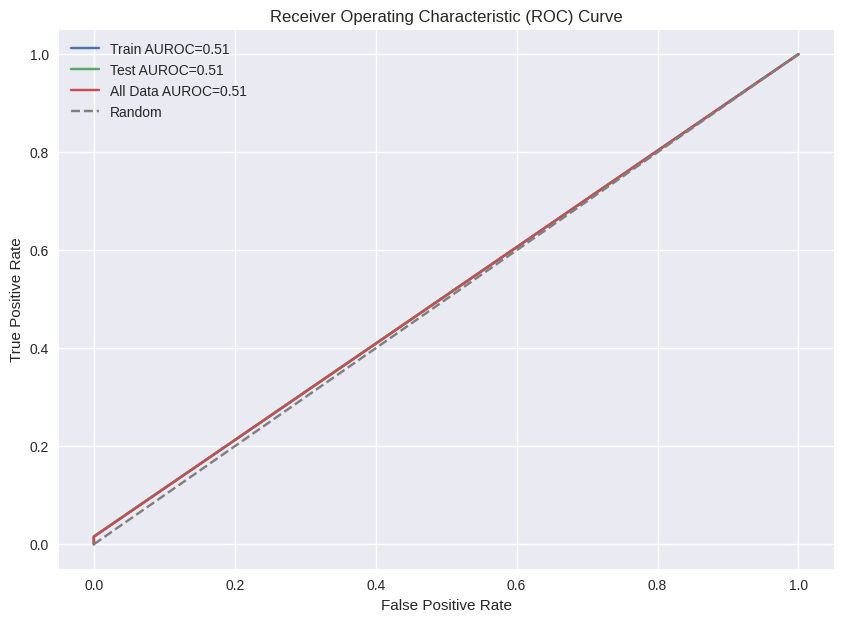

In [163]:
### ASSESS MODEL PERFORMANCE ###

# Predict labels for train, test, and all data
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
all_data_pred = xgb_model.predict(X)

# Balanced Accuracy
y_train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
y_test_accuracy = balanced_accuracy_score(y_test, y_test_pred)
all_data_accuracy = balanced_accuracy_score(Y, all_data_pred)

# F1 Score
y_train_f1 = f1_score(y_train, y_train_pred)
y_test_f1 = f1_score(y_test, y_test_pred)
all_data_f1 = f1_score(Y, all_data_pred)

# Precision
y_train_precision = precision_score(y_train, y_train_pred)
y_test_precision = precision_score(y_test, y_test_pred)
all_data_precision = precision_score(Y, all_data_pred)

# Recall
y_train_recall = recall_score(y_train, y_train_pred)
y_test_recall = recall_score(y_test, y_test_pred)
all_data_recall = recall_score(Y, all_data_pred)

# AUROC
y_train_auroc = roc_auc_score(y_train, y_train_pred)
y_test_auroc = roc_auc_score(y_test, y_test_pred)
all_data_auroc = roc_auc_score(Y, all_data_pred)

# AUC-PR (Area Under the Precision-Recall Curve)
y_train_p, y_train_r, _ = precision_recall_curve(y_train, y_train_pred)
y_test_p, y_test_r, _ = precision_recall_curve(y_test, y_test_pred)
all_data_p, all_data_r, _ = precision_recall_curve(Y, all_data_pred)

y_train_auc_pr = auc(y_train_r, y_train_p)
y_test_auc_pr = auc(y_test_r, y_test_p)
all_data_auc_pr = auc(all_data_r, all_data_p)

# Average Precision Score (APS)
y_train_aps = average_precision_score(y_train, y_train_pred)
y_test_aps = average_precision_score(y_test, y_test_pred)
all_data_aps = average_precision_score(Y, all_data_pred)

# Print Metrics
print(
    f"Balanced Accuracy\nTrain: {y_train_accuracy:.5f}  |  Test: {y_test_accuracy:.5f}  |  All Data: {all_data_accuracy:.5f}\n",
)
print(
    f"F1 Score\nTrain: {y_train_f1:.5f}  |  Test: {y_test_f1:.5f}  |  All Data: {all_data_f1:.5f}\n",
)
print(
    f"Precision\nTrain: {y_train_precision:.5f}  |  Test: {y_test_precision:.5f}  |  All Data: {all_data_precision:.5f}\n",
)
print(
    f"Recall\nTrain: {y_train_recall:.5f}  |  Test: {y_test_recall:.5f}  |  All Data: {all_data_recall:.5f}\n",
)
print(
    f"AUROC\nTrain: {y_train_auroc:.5f}  |  Test: {y_test_auroc:.5f}  |  All Data: {all_data_auroc:.5f}\n",
)
print(
    f"AUC-PR\nTrain: {y_train_auc_pr:.5f}  |  Test: {y_test_auc_pr:.5f}  |  All Data: {all_data_auc_pr:.5f}\n",
)
print(
    f"Average Precision Score\nTrain: {y_train_aps:.5f}  |  Test: {y_test_aps:.5f}  |  All Data: {all_data_aps:.5f}\n",
)

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
fpr_all_data, tpr_all_data, _ = roc_curve(Y, all_data_pred)

# Plot Information
plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label=f"Train AUROC={y_train_auroc:.2f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUROC={y_test_auroc:.2f}")
plt.plot(fpr_all_data, tpr_all_data, label=f"All Data AUROC={all_data_auroc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

In [164]:
# Save current predictions, labels, and probabilities to disk
np.save(f"{ROOT}/xgboost_y_test_pred_two_weeks.npy", y_test_pred)
np.save(f"{ROOT}/xgboost_y_test_pred_two_weeks_labels.npy", y_test)
np.save(
    f"{ROOT}/xgboost_y_test_pred_two_weeks_prob.npy", xgb_model.predict_proba(X_test)
)

In [ ]:
# CAREFUL, one needs to match feature ids to actual FHIR features before interpretation
# Assess which features are the most important

# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a list of tuples (feature, importance) and sort it by importance in descending order
sorted_importances = sorted(
    zip(selected_features, feature_importances), key=lambda x: x[1], reverse=True
)

# Display the top 10 most important features
top_features = sorted_importances[:10]
for feature, importance in top_features:
    print(f"{feature}: {importance}")

In [ ]:
### SCRIPT FOR K-FOLD VALIDATION ###
N_FOLDS = 10

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=23)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
f1_scores = []
precisions = []
recalls = []
aurocs = []
auc_prs = []
average_precision_scores = []

# Perform k-fold cross-validation
for train_index, test_index in tqdm(
    stratified_kfold.split(X, Y),
    desc=f"{N_FOLDS}-Fold Validation",
    unit=" Model(s)",
):
    # Get the relevant train and test data
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = Y[train_index], Y[test_index]

    # Create a new XGBoost model for each fold
    xgb_model = xgb.XGBClassifier(
        objective="binary:logistic", random_state=23, scale_pos_weight=scale_pos_weight
    )

    # Train the model on the training fold
    xgb_model.fit(X_train_fold, y_train_fold)

    # Predict on the test fold
    y_pred_fold = xgb_model.predict(X_test_fold)

    # Calculate performance metrics
    accuracy_fold = balanced_accuracy_score(y_test_fold, y_pred_fold)
    f1_fold = f1_score(y_test_fold, y_pred_fold)
    precision_fold = precision_score(y_test_fold, y_pred_fold)
    recall_fold = recall_score(y_test_fold, y_pred_fold)
    auroc_fold = roc_auc_score(y_test_fold, y_pred_fold)
    p_fold, r_fold, _ = precision_recall_curve(y_test_fold, y_pred_fold)
    auc_pr_fold = auc(r_fold, p_fold)
    average_precision_score_fold = average_precision_score(y_test_fold, y_pred_fold)

    # Append metrics to lists
    accuracy_scores.append(accuracy_fold)
    f1_scores.append(f1_fold)
    precisions.append(precision_fold)
    recalls.append(recall_fold)
    aurocs.append(auroc_fold)
    auc_prs.append(auc_pr_fold)
    average_precision_scores.append(average_precision_score_fold)

# Print average metrics across all folds
print(f"Average Balanced Accuracy: {sum(accuracy_scores) / N_FOLDS:.5f}")
print(f"Average F1 Score: {sum(f1_scores) / N_FOLDS:.5f}")
print(f"Average Precision: {sum(precisions) / N_FOLDS:.5f}")
print(f"Average Recall: {sum(recalls) / N_FOLDS:.5f}")
print(f"Average AUROC: {sum(aurocs) / N_FOLDS:.5f}")
print(f"Average AUC-PR: {sum(auc_prs) / N_FOLDS:.5f}")
print(f"Average Precision Score: {sum(average_precision_scores) / N_FOLDS:.5f}")